# Libraries Required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Dataset Loading

In [2]:
df = pd.read_csv('/content/patient.csv')

# Data

In [3]:
df.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,NaN,NaN,isolated


# Data Preprocessing & Feature Engineering

In [4]:
# Calculate Age from birth_year
if 'birth_year' in df.columns:
    df['age'] = 2026 - df['birth_year']

In [5]:
# Convert date columns to datetime objects
date_cols = ['confirmed_date', 'released_date', 'deceased_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

In [6]:
# Calculate Recovery Duration (Target Variable)
if 'confirmed_date' in df.columns and 'released_date' in df.columns:
    df['recovery_days'] = (df['released_date'] - df['confirmed_date']).dt.days
    # Clean data: only keep positive recovery values
    df = df[df['recovery_days'] >= 0]

# Exploratory Data Analysis

/tmp/ipython-input-2940211599.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sex', palette='Set2')


Text(0.5, 1.0, 'Infection Distribution by Gender')

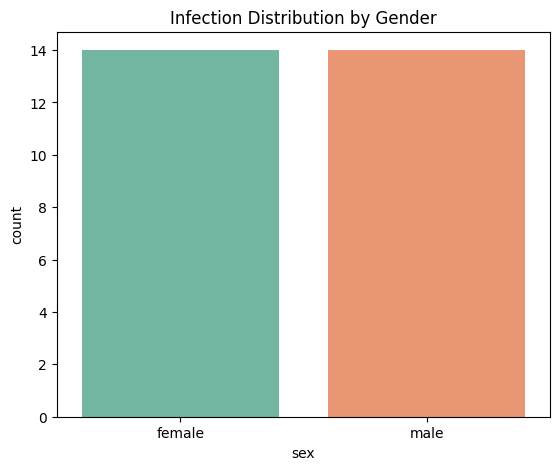

In [7]:
# Demographic Visualizations (Age and Gender)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sex', palette='Set2')
plt.title('Infection Distribution by Gender')

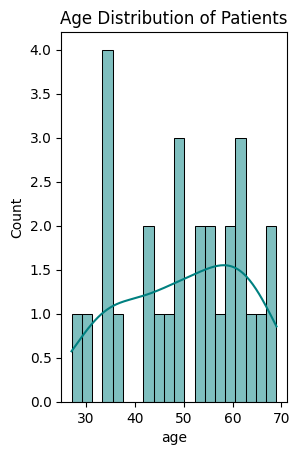

In [8]:
plt.subplot(1, 2, 2)
sns.histplot(df['age'], bins=20, kde=True, color='teal')
plt.title('Age Distribution of Patients')
plt.show()

/tmp/ipython-input-938822976.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')


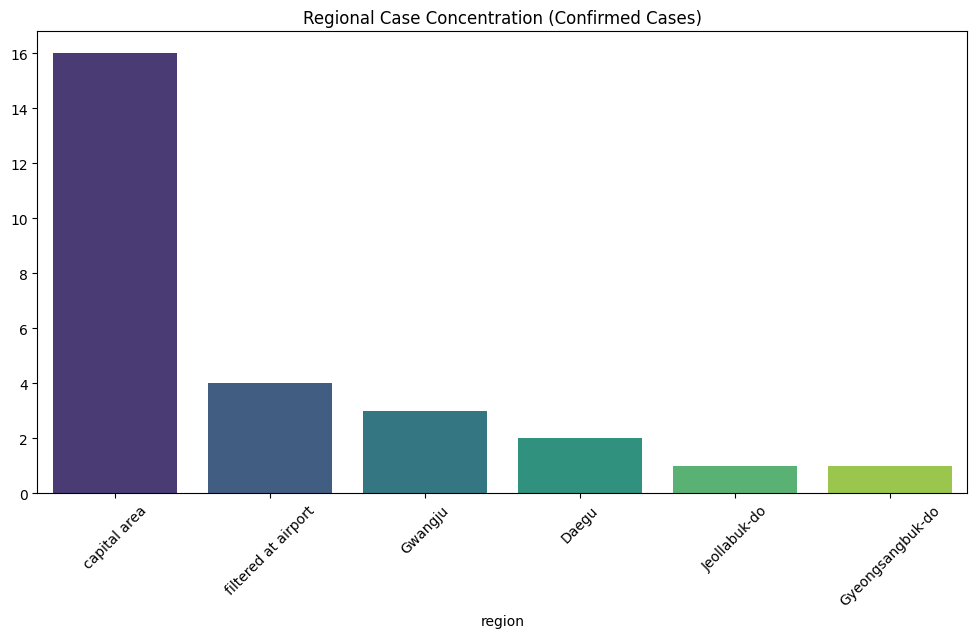

In [9]:
# Regional Case Concentration (Most Impacted Regions)
if 'region' in df.columns:
    plt.figure(figsize=(12, 6))
    region_counts = df['region'].value_counts()
    sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')
    plt.title('Regional Case Concentration (Confirmed Cases)')
    plt.xticks(rotation=45)
    plt.show()

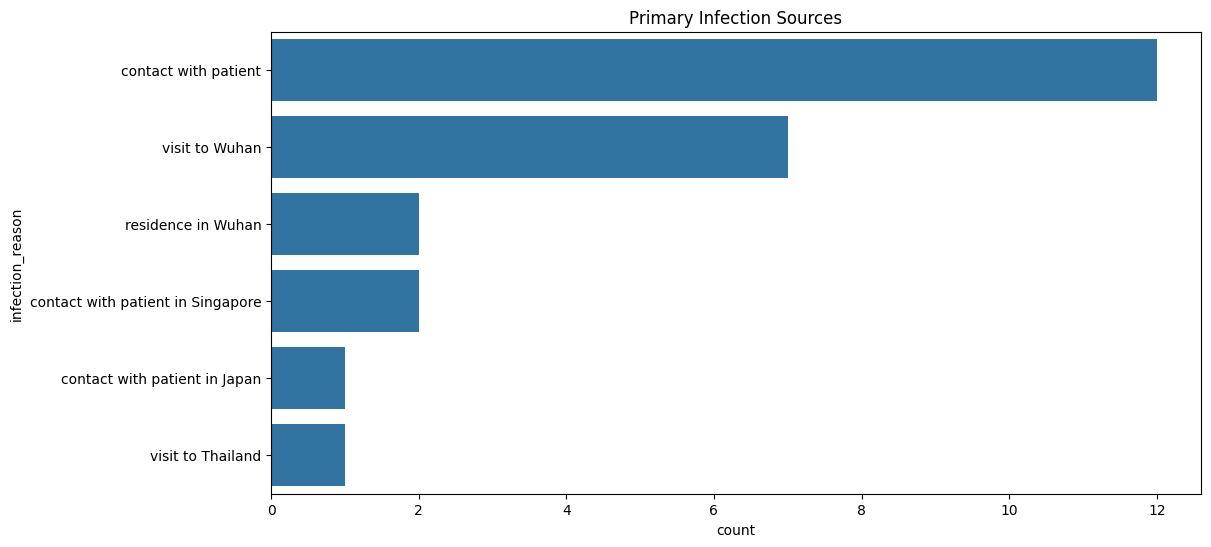

In [10]:
# Infection Sources (Spread Patterns)
if 'infection_reason' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(y='infection_reason', data=df, order=df['infection_reason'].value_counts().index)
    plt.title('Primary Infection Sources')
    plt.show()

# Outlier Detection

In [11]:
def handle_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Visualizing the outliers via Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='orange')
    plt.title(f'Outlier Detection: {column}')
    plt.show()

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

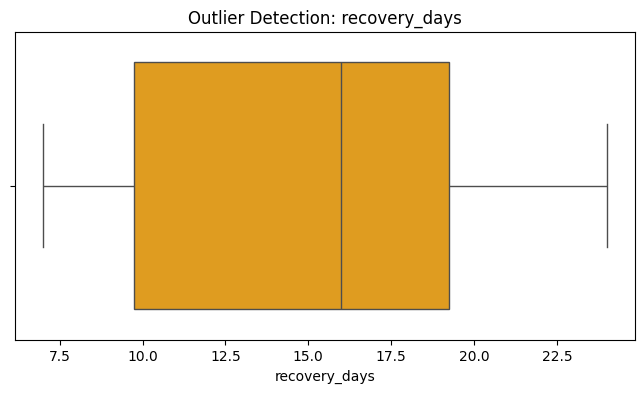

In [12]:
# Cleaning outliers for better regression performance
if 'recovery_days' in df.columns:
    df_cleaned = handle_outliers(df, 'recovery_days')

# Correlation Analysis

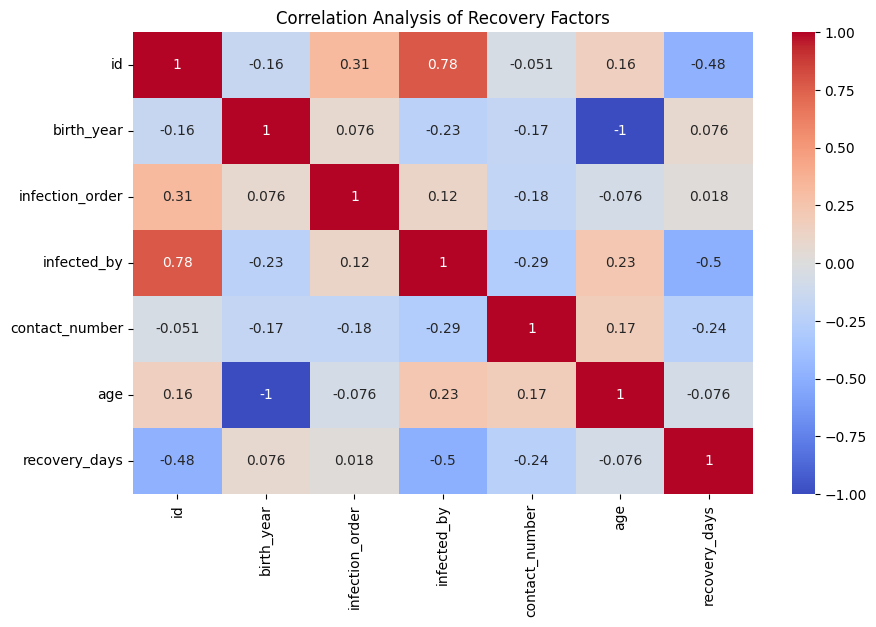

In [13]:
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Analysis of Recovery Factors')
plt.show()

# Linear Regression

Model R-squared Score: -0.6577


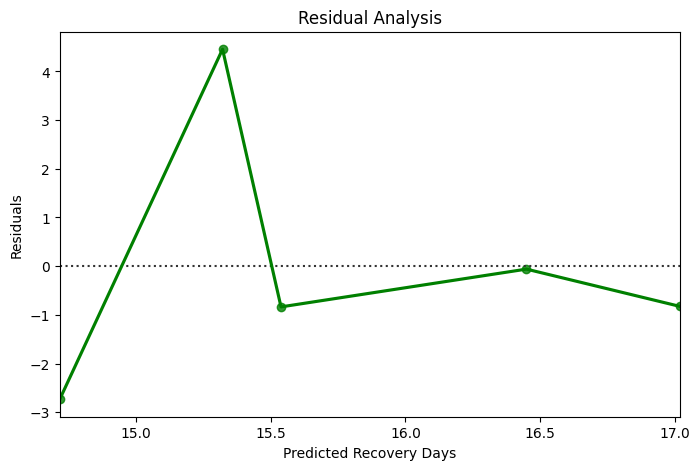

In [14]:
# Selecting influencing factors
features = ['age', 'contact_number', 'infection_order']
target = 'recovery_days'

# Drop missing values for the model
model_data = df_cleaned[features + [target]].dropna()

if not model_data.empty:
    X = model_data[features]
    y = model_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Model Evaluation (R2 and Residuals)
    y_pred = model.predict(X_test)
    print(f"Model R-squared Score: {r2_score(y_test, y_pred):.4f}")

    # Residual Analysis Plot
    plt.figure(figsize=(8, 5))
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color="g")
    plt.title('Residual Analysis')
    plt.xlabel('Predicted Recovery Days')
    plt.ylabel('Residuals')
    plt.show()
else:
    print("Insufficient data for Linear Regression.")

# Testing

In [15]:
input_age = 45           # Age of the patient
input_contacts = 10      # Number of people they contacted
input_order = 1          # Infection generation order (e.g., 1st, 2nd)

In [16]:
# Make Prediction
test_case = np.array([[input_age, input_contacts, input_order]])
prediction = model.predict(test_case)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [17]:
print(f"--- Prediction Result ---")
print(f"For a patient who is {input_age} years old with {input_contacts} contacts:")
print(f"Predicted Recovery Time: {prediction[0]:.2f} days")

--- Prediction Result ---
For a patient who is 45 years old with 10 contacts:
Predicted Recovery Time: 16.10 days
